## 随机梯度下降
前⾯的章节中，我们⼀直在训练过程中使⽤随机梯度下降，但没有解释它为什么起作⽤。为了澄清这⼀点，
我们刚在 11.3节中描述了梯度下降的基本原则。本节继续更详细地说明随机梯度下降（stochastic gradient
descent）。


In [3]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l


### 随机梯度更新
在深度学习中，⽬标函数通常是训练数据集中每个样本的损失函数的平均值。给定n个样本的训练数据集，我
们假设fi(x)是关于索引i的训练样本的损失函数，其中x是参数向量。然后我们得到⽬标函数

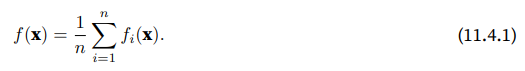

x的⽬标函数的梯度计算为

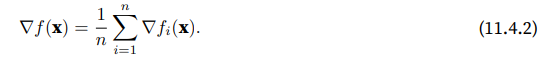

如果使⽤梯度下降法，则每个⾃变量迭代的计算代价为O(n)，它随n线性增⻓。因此，当训练数据集较⼤时，
每次迭代的梯度下降计算代价将较⾼。

随机梯度下降（SGD）可降低每次迭代时的计算代价。在随机梯度下降的每次迭代中，我们对数据样本随机
均匀采样⼀个索引i，其中i ∈ {1, . . . , n}，并计算梯度∇fi(x)以更新x：

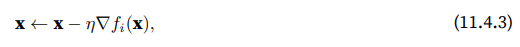

其中η是学习率。我们可以看到，每次迭代的计算代价从梯度下降的O(n)降⾄常数O(1)。此外，我们要强调，
随机梯度∇fi(x)是对完整梯度∇f(x)的⽆偏估计，因为

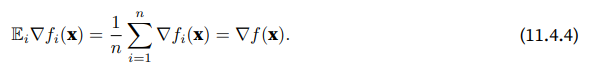

这意味着，平均⽽⾔，随机梯度是对梯度的良好估计。
现在，我们将把它与梯度下降进⾏⽐较，⽅法是向梯度添加均值为0、⽅差为1的随机噪声，以模拟随机梯度
下降。



In [4]:
def f(x1, x2): # ⽬标函数
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2): # ⽬标函数的梯度
    return 2 * x1, 4 * x2

In [7]:
# 缺少的函数
def train_2d(trainer, steps=20, f_grad=None): #@save
    """⽤定制的训练机优化2D⽬标函数"""
    # s1和s2是稍后将使⽤的内部状态变量
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

epoch 50, x1: 0.013338, x2: 0.060121


d:\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
d:\anaconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


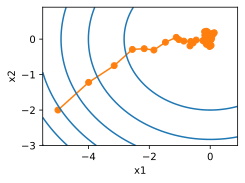

In [9]:
def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # 模拟有噪声的梯度
    g1 += torch.normal(0.0, 1, (1,))
    g2 += torch.normal(0.0, 1, (1,))
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)


def constant_lr():
    return 1

eta = 0.1
lr = constant_lr # 常数学习速度
d2l.show_trace_2d(f, train_2d(sgd, steps=50,  f_grad=f_grad))


正如我们所看到的，随机梯度下降中变量的轨迹⽐我们在 11.3节中观察到的梯度下降中观察到的轨迹嘈杂得
多。这是由于梯度的随机性质。也就是说，即使我们接近最⼩值，我们仍然受到通过η∇fi(x)的瞬间梯度所注
⼊的不确定性的影响。即使经过50次迭代，质量仍然不那么好。更糟糕的是，经过额外的步骤，它不会得到
改善。这给我们留下了唯⼀的选择：改变学习率η。但是，如果我们选择的学习率太⼩，我们⼀开始就不会取
得任何有意义的进展。另⼀⽅⾯，如果我们选择的学习率太⼤，我们将⽆法获得⼀个好的解决⽅案，如上所
⽰。解决这些相互冲突的⽬标的唯⼀⽅法是在优化过程中动态降低学习率。

这也是在sgd步⻓函数中添加学习率函数lr的原因。在上⾯的⽰例中，学习率调度的任何功能都处于休眠状
态，因为我们将相关的lr函数设置为常量。

### 动态学习率